In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from import_pkg import eigenform

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.utils.extmath import randomized_svd

In [4]:
data_dir = eigenform.get_data_dir()
with (data_dir / "char_img/char_img_shao.pkl").open("rb") as fin:
    M = pickle.load(fin)

In [5]:
## Some of the codes are extracted from
## https://github.com/seantyh/Fusiform/blob/master/40_Interface/eigen-character.ipynb

In [6]:
U, S, Vt = randomized_svd(M, n_components=500, random_state=3423)
svd_dir = eigenform.get_data_dir() / "svd"
with (svd_dir / "svd_shao").open("wb") as fout:
    pickle.dump((U, S, Vt), fout)
print(f"dimensions: U({U.shape}), S({S.shape}), V({Vt.shape})")

dimensions: U((4096, 500)), S((500,)), V((500, 6529))


In [ ]:
# save coefficient
def save_coeffs(chars, S, Vt):
    itos = {i: c for i, c in enumerate(chars)}
    stoi = {v: k for k, v in itos.items()}
    vectors = np.dot(np.diag(S), Vt)
    cv_path = Fusiform.get_data_path('', 'charac_coeff.pkl')
    with open(cv_path, "wb") as fout:
        pickle.dump((itos, stoi, vectors.transpose()), fout)

In [ ]:
save_coeffs(freq_str, S, Vt)
cv_path = Fusiform.get_data_path('', 'charac_coeff.pkl')
if cv_path.exists():
    with open(cv_path, "rb") as fin:
        cv_itos, cv_stoi, cv_vectors = pickle.load(fin)

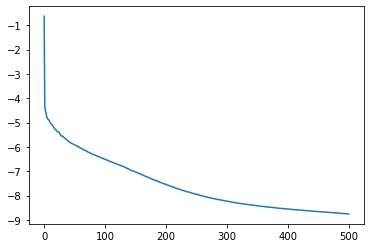

In [42]:
fnorm2 = np.sum(S**2)
S_prop = S**2/fnorm2
plt.plot(np.log(S_prop+1e-4))

## Recon

In [43]:
def recon_k(k, svd_tuple):    
    U, S, Vt = svd_tuple
    Uk, Sk, Vk = U[:,:k], S[:k], Vt[:k, :]
    Mk = np.dot(np.dot(Uk, np.diag(Sk)), Vk)
    size = (3, 6)
    fig, axes = plt.subplots(*size)
    fig.set_size_inches(12, 6)
    for i, ax in enumerate(chain.from_iterable(axes)):        
        if i < size[0]*size[1]/2:
            recon_x = eigenform.recon(Mk[:,i], 64)
        else:
            recon_x = eigenform.recon(Mk[:,1000+i], 64)
        ax.imshow(recon_x, cmap='gray')
        ax.axis('off')

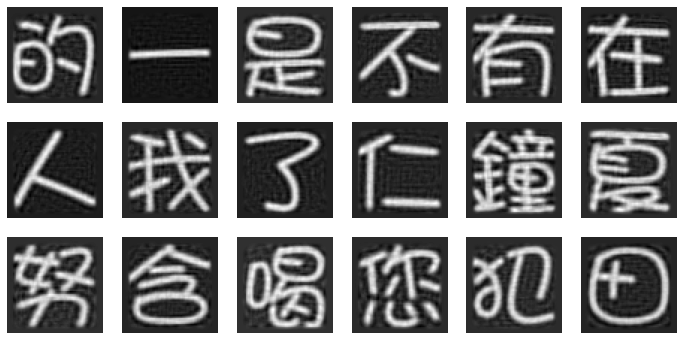

In [44]:
recon_k(300, (U, S, Vt))

In [38]:
def plot_ECs_50(offset=0):
    fig, axes = plt.subplots(5, 10, squeeze=False)
    fig.set_size_inches(12, 8)
    for v, ax in enumerate(chain.from_iterable(axes)):
        ec_i = v + offset
        ax.imshow(eigenform.recon(U[:,ec_i], 64), cmap='gray')
        ax.axis('off')
        ax.set_title(f'EC{ec_i}')
    return fig

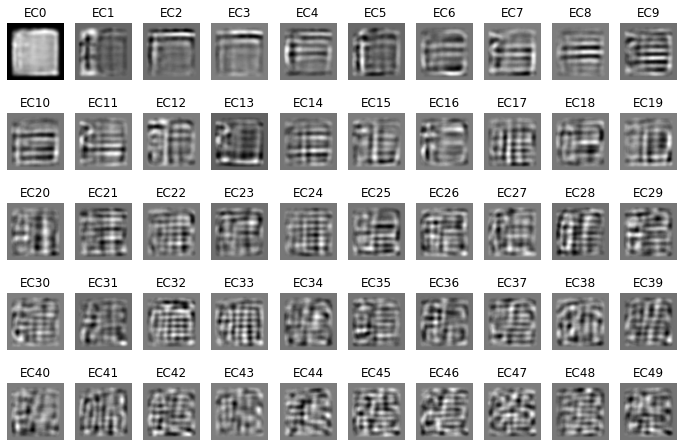

In [45]:
fig = plot_ECs_50()

## FormSpace

In [4]:
import json
with (eigenform.get_data_dir()/"vocabs.json").open("r", encoding="UTF-8") as fin:
    vocabs = json.load(fin)

In [5]:
hei_svd = eigenform.make_svd("hei")
hei_space = eigenform.FormSpace("hei", n_components=100, svd_tuple=hei_svd, vocabs=vocabs)

In [6]:
shao_svd = eigenform.make_svd("shao")
shao_space = eigenform.FormSpace("shao", n_components=100, svd_tuple=shao_svd, vocabs=vocabs)

## Alignment

In [11]:
shao_align_svd, supp = eigenform.align_space(shao_svd, hei_svd, 100)

In [13]:
Ua, Sa, Vta = shao_align_svd

In [15]:
Xa = Ua.dot(np.diag(Sa)).dot(Vta)

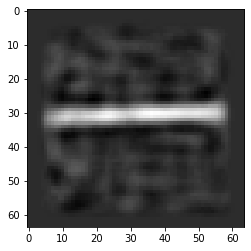

In [16]:
plt.imshow(eigenform.recon(Xa[:,1], 64), cmap="gray")

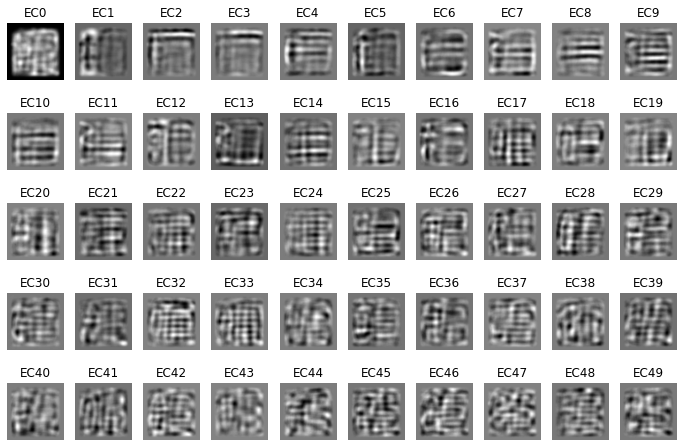

In [18]:
fig, axes = plt.subplots(5, 10, squeeze=False)
fig.set_size_inches(12, 8)
for v, ax in enumerate(chain.from_iterable(axes)):
    ec_i = v
    ax.imshow(eigenform.recon(Ua[:,ec_i], 64), cmap='gray')
    ax.axis('off')
    ax.set_title(f'EC{ec_i}')

In [165]:
cV = shao_V - shao_V.mean(0)

In [169]:
ncV = (cV / np.sqrt((cV**2).sum(0)))

In [171]:
(ncV**2).sum(0).shape

(6529,)